# 03 Embedding Accuracy Test

This notebook contains the embedding accuracy sanity check as described in section 4.1.4 of the thesis. Results might vary as Wikipedia articles change.

## Imports

In [7]:
import bs4
import requests
import unicodedata
import re
import wikipedia as wp
import bertFuncs as func
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
import ast
import itertools
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

2023-02-20 18:10:37.941225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 18:10:45.651358: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 18:11:05.949788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-02-20 18:11:05.982114: W tensorflow/compil

In [41]:
# Getting all articles for the firm name for manual labeling. 

"""

firms = pd.read_csv("sp500companynames_clean.csv", sep = ";", index_col = 0).dropna()

def get_num_article(row):
    return wp.search(row["cleanedname"])

firms["Articles"] = firms.progress_apply(lambda row: get_num_article(row), axis = 1)

firms.to_csv("sp500")

In [8]:
# Get BERT. 
tqdm.pandas()
tokenizer, model = func.getBert()

# Read firms with manually labeled correct wikipedia article. 
single_word_firms = pd.read_csv("single_firm_articles_labeled.csv", sep = ";", index_col = 0)

# Filter out firms where no corporate article was identified. 
single_word_firms = single_word_firms[single_word_firms["Correct Article"] != "No"]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Extract correct Wikipedia article that was manually labeled by specifying the index of the correct entry. 

def get_correct_article(row): 
    article_index = int(row["Correct Article"])
    article_list = ast.literal_eval(row["Articles"])
    return article_list[article_index]

single_word_firms["Article_Name"] = single_word_firms.progress_apply(lambda row: get_correct_article(row), axis = 1)

  0%|          | 0/209 [00:00<?, ?it/s]

In [3]:
# Helper function to get clean paragraphs for wikipedia articles. 
# Modified from https://stackoverflow.com/questions/66295262/how-to-split-a-wikipedia-page-into-paragraphs-using-python

def get_paragraphs(page_name):

    r = requests.get('https://en.wikipedia.org/api/rest_v1/page/html/{0}'.format(page_name))
    soup = bs4.BeautifulSoup(r.content)
    html_paragraphs = soup.find_all('p')

    for p in html_paragraphs:
        cleaned_text = re.sub('(\[[0-9]+\])', '', unicodedata.normalize('NFKD', p.text)).strip()
        if cleaned_text:
            yield cleaned_text

## 1. Pronoun Embedding Analysis

In [5]:
def assess_performance(row):
    
    try: 
    
        # Define different names. 
        company_clean = row["cleanedname"].lower() # Clean company name 
        company_corp = row["companyname"].lower() # Clean name + incorporation form 
        company_corporation_clean = f"the corporation {company_clean}" # "the corporation" prefix + clean name 
        company_corporation_corp = f"the corporation {company_corp}" # "the corporation" prefix + clean name + incorporation  

        # Search for all Wikipedia articles with clean company name.
        articles = wp.search(company_clean)

        sentence_df = pd.DataFrame({"Article":[], "Sentence":[]})

        # Loop through all articles and their sentences. 
        for article in articles: 

            # Get clean paragraphs of each article. 
            paragraphs = list(get_paragraphs(article))

            for paragraph in paragraphs: 
                sentences = paragraph.split(". ")

                for sentence in sentences: 

                    # If sentence contains company name, append to df. 
                    if company_clean in sentence.lower(): 
                        sentence_df.loc[len(sentence_df)] = [article, sentence.lower()]

        # Remove punctuation and replace plural forms. 
        sentence_df["Sentence"] = sentence_df['Sentence'].replace('[^\w\s]','')
        sentence_df["Sentence"] = sentence_df['Sentence'].replace(f'{company_clean}s',f'{company_clean}')
        sentence_df["Sentence"] = sentence_df['Sentence'].replace('-'," ")

        # Append different types of firm embeddings. 
        context_list = ["works", "worked", "will work", "has worked", "is working","is employed", "was employed", "will be employed", "has been employed"]
        pronouns = ["He", "She"]

        for context, pronoun in itertools.product(context_list, pronouns): 
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corp}", f"{pronoun} {context} at {company_corp}"]
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_clean}", f"{pronoun} {context} at {company_clean}"]
            
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corporation_clean}", f"{pronoun} {context} at {company_corporation_clean}"]
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corporation_corp}", f"{pronoun} {context} at {company_corporation_corp}"]
            
            
        # Get BERT embeddings for all Wikipedia sentences by embedding the firm name. 
        sentence_embeddings = pd.DataFrame()
        for sentence in sentence_df[~sentence_df['Article'].str.contains("Firm Embedding")]["Sentence"]: 
            try: 
                sentence_bert_embedding = func.forwardWord(sentence = sentence, word = company_clean, model=model, tokenizer = tokenizer)
                sentence_bert_embedding_df = pd.DataFrame(sentence_bert_embedding).transpose()
                sentence_bert_embedding_df.insert(loc = 0, column = "Sentence", value = sentence)
                sentence_embeddings = pd.concat([sentence_embeddings, sentence_bert_embedding_df])

            except: 
                pass

        sentence_embeddings = sentence_embeddings.reset_index(drop = True)


        # Get BERT embeddings for all firm sentences by embedding the pronoun. 
        for sentence in sentence_df[sentence_df['Article'].str.contains("Firm Embedding")]["Sentence"]: 
            try: 
                sentence_bert_embedding = func.forwardWord(sentence = sentence, word = sentence.split(" ")[0], model=model, tokenizer = tokenizer)
                sentence_bert_embedding_df = pd.DataFrame(sentence_bert_embedding).transpose()
                sentence_bert_embedding_df.insert(loc = 0, column = "Sentence", value = sentence)
                sentence_embeddings = pd.concat([sentence_embeddings, sentence_bert_embedding_df])

            except: 
                pass

        sentence_embeddings = sentence_embeddings.reset_index(drop = True)


        # Create final dataframe. 
        final_df = sentence_df.merge(sentence_embeddings, on='Sentence', how='outer')
        final_df = final_df.dropna()


        # Evaluate Classification. 

        # Define correct company article name. 
        company_article = row["Article_Name"]


        # Train logistic regression on all Wikipedia Sentences. 
        X_train = final_df[~final_df['Article'].str.contains("Firm Embedding")].drop(["Article", "Sentence"], axis = 1)
        y_train = final_df[~final_df['Article'].str.contains("Firm Embedding")]["Article"]

        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        

        # Create different test sets for different methods. 

        # Clean Company Name. 
        X_test_company_clean = final_df[final_df['Article'] == f"Firm Embedding {company_clean}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_clean = len(X_test_company_clean) * [company_article]

        # Company Name + Legal Form. 
        X_test_company_corp = final_df[final_df['Article'] == f"Firm Embedding {company_corp}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_corp = len(X_test_company_corp) * [company_article]

        # Corporation Prefix + Clean Company Name 
        X_test_company_corporation_clean= final_df[final_df['Article'] == f"Firm Embedding {company_corporation_clean}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_corporation_clean = len(X_test_company_corporation_clean) * [company_article]

        # Corporation Prefix + Clean Company Name + Legal Form 
        X_test_company_corporation_corp = final_df[final_df['Article'] == f"Firm Embedding {company_corporation_corp}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_corporation_corp = len(X_test_company_corporation_corp) * [company_article]
        
        # Get predictions for test data. 
        predictions_method1 = lr.predict(X_test_company_clean)
        predictions_method2 = lr.predict(X_test_company_corp)
        predictions_method3 = lr.predict(X_test_company_corporation_clean)
        predictions_method4 = lr.predict(X_test_company_corporation_corp)

        # Get Accuracy Score. 
        accuracy_method1 = accuracy_score(y_test_company_clean, predictions_method1)
        accuracy_method2 = accuracy_score(y_test_company_corp, predictions_method2)
        accuracy_method3 = accuracy_score(y_test_company_corporation_clean, predictions_method3)
        accuracy_method4 = accuracy_score(y_test_company_corporation_corp, predictions_method4)

        return pd.Series([accuracy_method1, accuracy_method2, accuracy_method3, accuracy_method4])

    except: 
        return ['NaN', 'NaN', 'NaN', "NaN"]

In [6]:
# Run the analysis. 
single_word_firms[["Accuracy Method 1", "Accuracy Method 2", "Accuracy Method 3", "Accuracy Method 4"]] = single_word_firms.progress_apply(lambda row: assess_performance(row), axis = 1)

  0%|          | 0/209 [00:00<?, ?it/s]

In [8]:
# Save results. 
single_word_firms.to_csv("embedding_pronouns_performance_evaluation.csv")

## 2. Firm Embedding Analysis

In [ ]:
def assess_performance(row):
    
    try: 
    
        # Define names
        company_clean = row["cleanedname"].lower() # Clean company name 
        company_corp = row["companyname"].lower() # Clean name + incorporation form 
        company_corporation_clean = f"the company {company_clean}" # "the corporation" prefix + clean name 
        company_corporation_corp = f"the company {company_corp}" # "the corporation" prefix + clean name + incorporation

        # Search for all Wikipedia articles with clean company name.
        articles = wp.search(company_clean)

        sentence_df = pd.DataFrame({"Article":[], "Sentence":[]})

        # Loop through all articles and their sentences. 
        for article in articles: 

            # Get clean paragraphs of each article. 
            paragraphs = list(get_paragraphs(article))

            for paragraph in paragraphs: 
                sentences = paragraph.split(". ")

                for sentence in sentences: 

                    # If sentence contains company name, append to df. 
                    if company_clean in sentence.lower(): 
                        sentence_df.loc[len(sentence_df)] = [article, sentence.lower()]

        # Remove punctuation and replace plural forms. 
        sentence_df["Sentence"] = sentence_df['Sentence'].replace('[^\w\s]','')
        sentence_df["Sentence"] = sentence_df['Sentence'].replace(f'{company_clean}s',f'{company_clean}')
        sentence_df["Sentence"] = sentence_df['Sentence'].replace('-'," ")


        # Append different types of firm embeddings. 
        context_list = ["works", "worked", "will work", "has worked", "is working","is employed", "was employed", "will be employed", "has been employed"]
        pronouns = ["He", "She"]

        for context, pronoun in itertools.product(context_list, pronouns): 
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corp}", f"{pronoun} {context} at {company_corp}"]
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_clean}", f"{pronoun} {context} at {company_clean}"]
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corporation_clean}", f"{pronoun} {context} at {company_corporation_clean}"]
            sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corporation_corp}", f"{pronoun} {context} at {company_corporation_corp}"]
            
            
        # Get BERT embeddings for all Wikipedia sentences. 

        sentence_embeddings = pd.DataFrame()

        for sentence in sentence_df["Sentence"]: 
            try: 
                sentence_bert_embedding = func.forwardWord(sentence = sentence, word = company_clean, model=model, tokenizer = tokenizer)
                sentence_bert_embedding_df = pd.DataFrame(sentence_bert_embedding).transpose()
                sentence_bert_embedding_df.insert(loc = 0, column = "Sentence", value = sentence)
                sentence_embeddings = pd.concat([sentence_embeddings, sentence_bert_embedding_df])

            except: 
                pass

        sentence_embeddings = sentence_embeddings.reset_index(drop = True)


        # Create final dataframe. 
        final_df = sentence_df.merge(sentence_embeddings, on='Sentence', how='outer')
        final_df = final_df.dropna()


        # Evaluate Classification. 

        # Define correct company article name. 
        company_article = row["Article_Name"]

        # Train logistic regression on all Wikipedia Sentences. 

        X_train = final_df[~final_df['Article'].str.contains("Firm Embedding")].drop(["Article", "Sentence"], axis = 1)
        y_train = final_df[~final_df['Article'].str.contains("Firm Embedding")]["Article"]

        lr = LogisticRegression()
        lr.fit(X_train, y_train)


        # Create different test sets for different methods. 

        # Clean Company Name. 
        X_test_company_clean = final_df[final_df['Article'] == f"Firm Embedding {company_clean}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_clean = len(X_test_company_clean) * [company_article]

        # Company Name + Legal Form.  
        X_test_company_corp = final_df[final_df['Article'] == f"Firm Embedding {company_corp}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_corp = len(X_test_company_corp) * [company_article]

        # Corporation Prefix + Clean Company Name
        X_test_company_corporation_clean= final_df[final_df['Article'] == f"Firm Embedding {company_corporation_clean}"].drop(["Article", "Sentence"], axis = 1)
        y_test_company_corporation_clean = len(X_test_company_corporation_clean) * [company_article]
        
        # Corporation Prefix + Clean Company Name + Legal Form 
        X_test_company_corporation_corp= final_df[final_df['Article'] == f"Firm Embedding {company_corporation_corp}"].drop(["Article", "Sentence"], axis = 1)
        y_test_ccompany_corporation_corp = len(X_test_company_corporation_corp) * [company_article]

        # Get predictions for test data. 
        predictions_method1 = lr.predict(X_test_company_clean)
        predictions_method2 = lr.predict(X_test_company_corp)
        predictions_method3 = lr.predict(X_test_company_corporation_clean)
        predictions_method4 = lr.predict(X_test_company_corporation_corp)

        # Get Accuracy Score. 
        accuracy_method1 = accuracy_score(y_test_company_clean, predictions_method1)
        accuracy_method2 = accuracy_score(y_test_company_corp, predictions_method2)
        accuracy_method3 = accuracy_score(y_test_company_corporation_clean, predictions_method3)
        accuracy_method4 = accuracy_score(y_test_ccompany_corporation_corp, predictions_method4)

        return pd.Series([accuracy_method1, accuracy_method2, accuracy_method3, accuracy_method4])

    except: 
        return ['NaN', 'NaN', 'NaN', "NaN"]

In [6]:
# Run the analysis
single_word_firms[["Accuracy Method 1", "Accuracy Method 2", "Accuracy Method 3", "Accuracy Method 4"]] = single_word_firms.progress_apply(lambda row: assess_performance(row), axis = 1)

  0%|          | 0/209 [00:00<?, ?it/s]

In [7]:
# Save results. 
single_word_firms.to_csv("embedding_firms_performance_evaluation.csv")

## 3. Analyze Results

In [26]:
# Read results. 
single_word_firms_embedding_firms = pd.read_csv("embedding_firms_performance_evaluation.csv")
single_word_firms_embedding_pronouns = pd.read_csv("embedding_pronouns_performance_evaluation.csv")

In [27]:
# Filter out NaNs. 
single_word_firms_embedding_firms = single_word_firms_embedding_firms.dropna()
single_word_firms_embedding_pronouns = single_word_firms_embedding_pronouns.dropna()

In [28]:
# Compare Means. 
single_word_firms_embedding_pronouns[["Accuracy Method 1", "Accuracy Method 2", "Accuracy Method 3", "Accuracy Method 4"]].mean()

Accuracy Method 1    0.624932
Accuracy Method 2    0.653659
Accuracy Method 3    0.642547
Accuracy Method 4    0.648780
dtype: float64

In [29]:
# Compare Means. 
single_word_firms_embedding_firms[["Accuracy Method 1", "Accuracy Method 2", "Accuracy Method 3", "Accuracy Method 4"]].mean()

Accuracy Method 1    0.639566
Accuracy Method 2    0.690786
Accuracy Method 3    0.659621
Accuracy Method 4    0.715447
dtype: float64

In [ ]:
# Conduct t-test for difference between methods. 
stat, p_value = ttest_ind(single_word_firms["Accuracy Method 1"].astype(float), single_word_firms["Accuracy Method 4"].astype(float))

### Plotting Results

In [45]:
embedding_pronouns = pd.DataFrame({"Accuracy":[single_word_firms_embedding_pronouns["Accuracy Method 1"].mean(),
                                               single_word_firms_embedding_pronouns["Accuracy Method 2"].mean(),
                                               single_word_firms_embedding_pronouns["Accuracy Method 3"].mean(),
                                               single_word_firms_embedding_pronouns["Accuracy Method 4"].mean()], 
                      "Method": ["Name", "Name + Legal", "Company Prefix \n+ Name", "Compan Prefix \n+ Name + Legal"] 
})

In [46]:
embedding_firms = pd.DataFrame({"Accuracy":[single_word_firms_embedding_firms["Accuracy Method 1"].mean(),
                                               single_word_firms_embedding_firms["Accuracy Method 2"].mean(),
                                               single_word_firms_embedding_firms["Accuracy Method 3"].mean(),
                                               single_word_firms_embedding_firms["Accuracy Method 4"].mean()], 
                      "Method": ["Name", "Name + Legal", "Company Prefix \n+ Name", "Compan Prefix \n+ Name + Legal"] 
})

[(0.5, 0.8)]

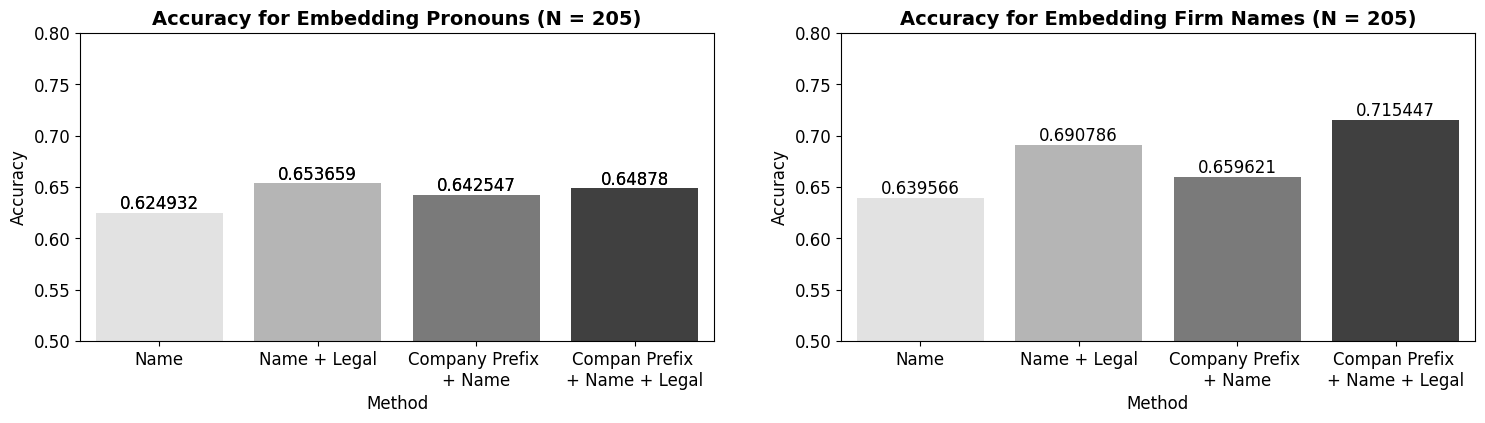

In [54]:
# plot token counts
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols=2, figsize=(18, 4))

ax1.set_title("Accuracy for Embedding Pronouns (N = 205)", weight = "bold", size = 14)
sns.barplot(data = embedding_pronouns, x = "Method", y = "Accuracy", ax = ax1, palette = "Greys")
ax1.bar_label(ax1.containers[0])
ax1.set(ylim=(0, 1))

ax2.set_title("Accuracy for Embedding Firm Names (N = 205)", weight = "bold", size = 14)
sns.barplot(data = embedding_firms, x = "Method", y = "Accuracy", ax = ax2, palette = "Greys")

for container in ax2.containers:
    ax2.bar_label(container)
ax2.set(ylim=(0.5, 0.8))

for container in ax1.containers:
    ax1.bar_label(container)
ax1.set(ylim=(0.5, 0.8))

In [55]:
#fig.savefig("embedding_accuracy.pdf", bbox_inches='tight')

## 4. Conduct Analysis for Single Company

In [9]:
# Define clean company name. 
company_name = "Amazon" 
company_corp = "Amazon Com Inc"
company_corp_company= "the corporation Amazon Com Inc"
            
# Search for all Wikipedia articles with clean company name.
articles = wp.search(company_name)

sentence_df = pd.DataFrame({"Article":[], "Sentence":[]})

# Loop through all articles and their sentences. 
for article in tqdm(articles): 
    
    # Get clean paragraphs of each article. 
    paragraphs = list(get_paragraphs(article))
    
    for paragraph in paragraphs: 
        sentences = paragraph.split(". ")
        
        for sentence in sentences: 
            
            # If sentence contains company name, append to df. 
            if company_name in sentence: 
                sentence_df.loc[len(sentence_df)] = [article, sentence]
                
# Remove punctuation and replace plural forms. 
sentence_df["Sentence"] = sentence_df['Sentence'].str.replace('[^\w\s]','')
sentence_df["Sentence"] = sentence_df['Sentence'].str.replace(f'{company_name}s',f'{company_name}')
sentence_df["Sentence"] = sentence_df['Sentence'].str.replace('-'," ")

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
# Append firm embeddings. 

context_list = ["works", "worked", "will work", "has worked", "is working","is employed", "was employed", "will be employed", "has been employed"]
pronouns = ["He", "She"]

for context, pronoun in itertools.product(context_list, pronouns): 
    sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corp}", f"{pronoun} {context} at {company_corp}"]
    sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_name}", f"{pronoun} {context} at {company_name}"]
    sentence_df.loc[len(sentence_df)] = [f"Firm Embedding {company_corp_company}", f"{pronoun} {context} at {company_corp_company}"]

In [11]:
# Get BERT embeddings for all Wikipedia sentences. 

tokenizer, model = func.getBert()

sentence_embeddings = pd.DataFrame()

for sentence in tqdm(sentence_df[~sentence_df['Article'].str.contains("Firm Embedding")]["Sentence"]): 
    try: 
        sentence_bert_embedding = func.forwardWord(sentence = sentence, word = company_name, model=model, tokenizer = tokenizer)
        sentence_bert_embedding_df = pd.DataFrame(sentence_bert_embedding).transpose()
        sentence_bert_embedding_df.insert(loc = 0, column = "Sentence", value = sentence)
        sentence_embeddings = pd.concat([sentence_embeddings, sentence_bert_embedding_df])
        
    except: 
        pass
    
sentence_embeddings = sentence_embeddings.reset_index(drop = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/854 [00:00<?, ?it/s]

In [12]:
# Get embeddings for all firm embeddings by embedding the pronoun. 

for sentence in tqdm(sentence_df[sentence_df['Article'].str.contains("Firm Embedding")]["Sentence"]): 
    try: 
        sentence_bert_embedding = func.forwardWord(sentence = sentence, word = sentence.split(" ")[0], model=model, tokenizer = tokenizer)
        sentence_bert_embedding_df = pd.DataFrame(sentence_bert_embedding).transpose()
        sentence_bert_embedding_df.insert(loc = 0, column = "Sentence", value = sentence)
        sentence_embeddings = pd.concat([sentence_embeddings, sentence_bert_embedding_df])
        
    except: 
        pass
    
sentence_embeddings = sentence_embeddings.reset_index(drop = True)

  0%|          | 0/54 [00:00<?, ?it/s]

In [13]:
final_df = sentence_df.merge(sentence_embeddings, on='Sentence', how='outer')
final_df = final_df.dropna()

Text(0.5, 1.0, 'First two TSNE Dimensions for BERT Embeddings of Wikipedia Sentences Containing the Word Amazon')

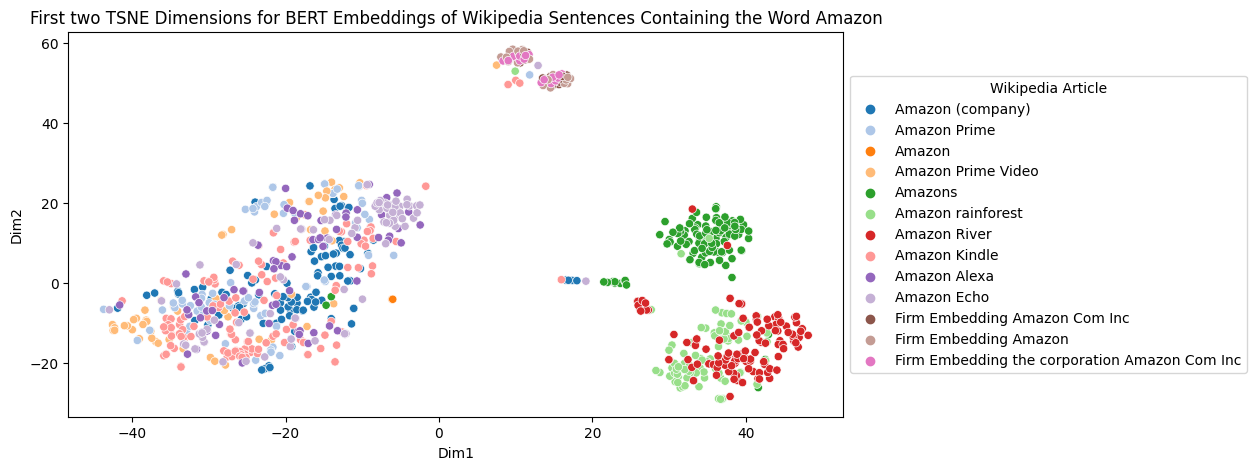

In [15]:
# Plot results. 

X_tsne_doc = TSNE(n_components=2, random_state=32, perplexity = 30, n_iter = 3000).fit_transform(final_df.drop(["Article","Sentence"], axis = 1))
select_df = pd.DataFrame({"Type":final_df["Article"], "Dim1":X_tsne_doc[:,0], "Dim2":X_tsne_doc[:,1]})

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = select_df, x = "Dim1", y = "Dim2", hue = "Type", palette = 'tab20', ax = ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Wikipedia Article")
ax.set_title(f"First two TSNE Dimensions for BERT Embeddings of Wikipedia Sentences Containing the Word {company_name}")
#plt.savefig('Wikipedia_TSNE.png', bbox_inches='tight',transparent=True)